# Analysis and generation of experience data collected from the simulation

## 1. Import and filter data


before: 
(20000, 40)
after: 
(18794, 42)


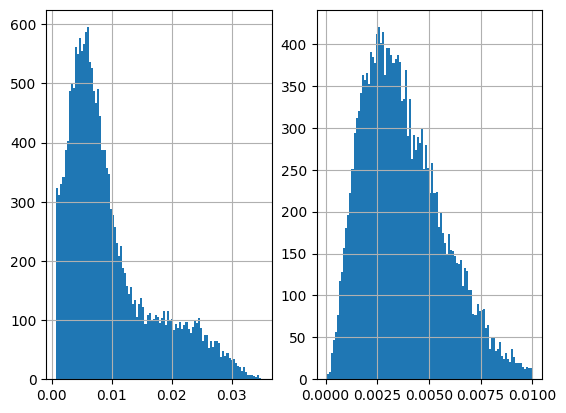

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./data/exp.csv', header=None)

# print shape of the dataframe
print("before: ")
print(df.shape)

# information of the dataframe
# 0-11: obs
# 12-14: achieved_goal
# 15-17: desired_goal
# 18-20: action
# 21: reward
# 22-33: next_obs
# 34-36: next_achieved_goal
# 37-39: next_desired_goal

# make last column to be the distance between obs and next_obs
df[40] = ((df[0] - df[22])**2 + (df[1] - df[23])**2 + (df[2] - df[24])**2)**0.5

# make last column to be the distance between desired_goal and next_desired_goal
df[41] = ((df[15] - df[37])**2 + (df[16] - df[38])**2 + (df[17] - df[39])**2)**0.5

# remove rows that has distance < 0.01
df = df[df[40] > 0.0008]
df = df[df[40] < 0.035]

# remove rows that has distance > 0.1
df = df[df[41] < 0.01]

fig, ax = plt.subplots(1, 2)

# plot the distribution of column 37
df[40].hist(bins=100, ax=ax[0])

# plot the distribution of column 38
df[41].hist(bins=100, ax=ax[1])

print("after: ")
print(df.shape)

## 2. Train a linear question model in order to predict the next gripper position based on the selected action and the original gripper position

0.9824602014026738


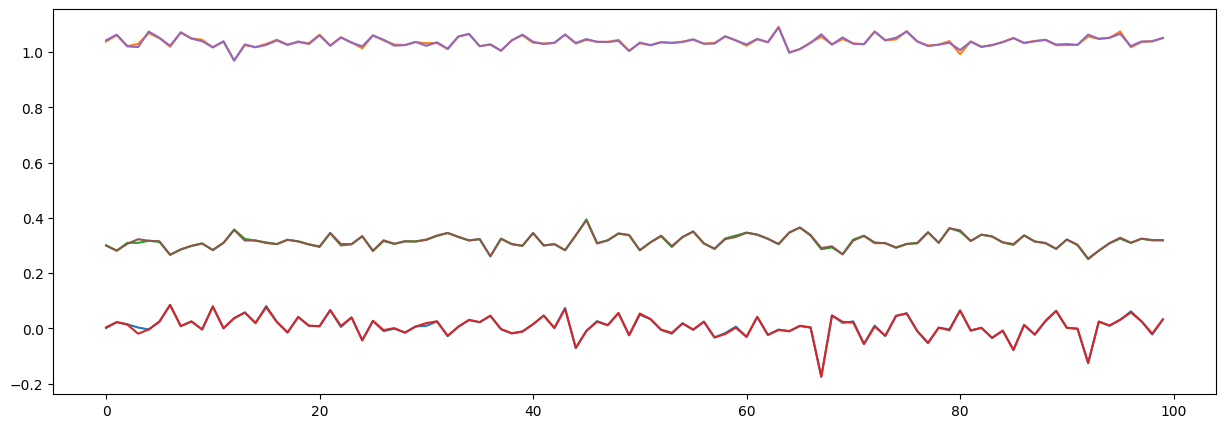

In [2]:
grip_pos = df[[0, 1, 2]]
grip_pos_next = df[[22, 23, 24]].rename(columns={22: 0, 23: 1, 24: 2})
action = df[[18, 19, 20]].rename(columns={18: 3, 19: 4, 20: 5})

# seperate the data into training and testing
from sklearn.model_selection import train_test_split
grip_pos_train, grip_pos_test, grip_pos_next_train, grip_pos_next_test, action_train, action_test = train_test_split(grip_pos, grip_pos_next, action, test_size=0.2, random_state=42)

# # use linear regression to predict the next grip position
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(grip_pos_train.join(action_train), grip_pos_next_train)

# print the score
print(reg1.score(grip_pos_test.join(action_test), grip_pos_next_test))

pred = reg1.predict(grip_pos_test.join(action_test))
actual = grip_pos_next_test

# reset index of actual to 0 to len(actual)
actual = actual.reset_index(drop=True)

# plot the results
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(actual[:100], label='actual')
plt.plot(pred[:100], label='pred')

## 3. Train a linear regression model in order to predict the next target position based on the target relative position and the target original position

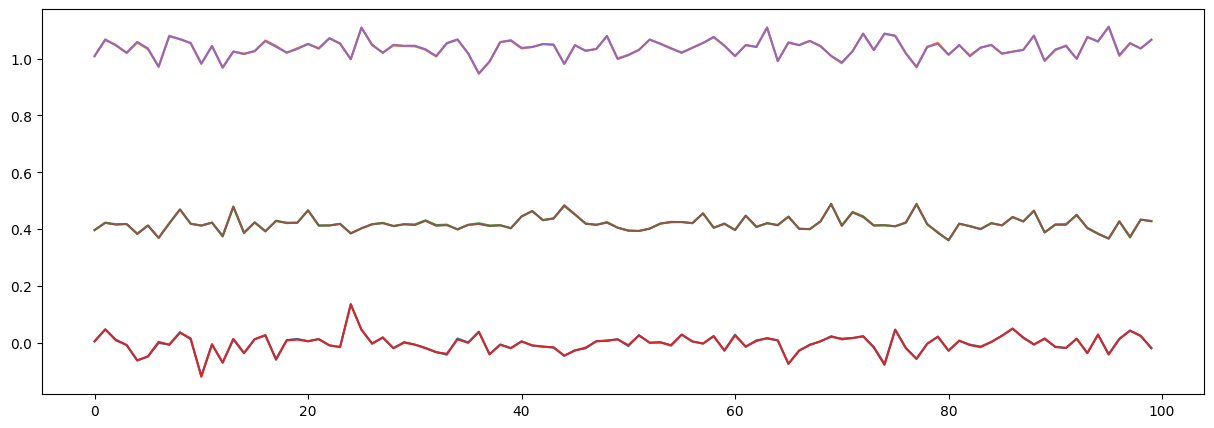

In [3]:
target_pos = df[[3, 4, 5]].rename(columns={3: 0, 4: 1, 5: 2})
target_pos_next = df[[25, 26, 27]].rename(columns={25: 0, 26: 1, 27: 2})
target_rel_vel = df[[9, 10, 11]].rename(columns={9: 3, 10: 4, 11: 5})

# seperate the data into training and testing
target_pos_train, target_pos_test, target_pos_next_train, target_pos_next_test, target_rel_vel_train, target_rel_vel_test = train_test_split(target_pos, target_pos_next, target_rel_vel, test_size=0.2, random_state=42)

# use linear regression to predict the next position of the target from the current position and relative velocity
reg2 = LinearRegression().fit(target_pos_train.join(target_rel_vel_train), target_pos_next_train)

# predict the next position of the target from the current position and relative velocity
target_pos_next_pred = reg2.predict(target_pos_test.join(target_rel_vel_test))
pred = target_pos_next_pred
actual = target_pos_next_test
actual = actual.reset_index(drop=True)

# plot the result
plt.figure(figsize=(15, 5))
plt.plot(actual[:100], label='actual')
plt.plot(pred[:100], label='pred')



## 4. Generate more data for the gripper position

grip_pos_min:  0   -0.192695
1    0.935341
2    0.221325
dtype: float64
grip_pos_max:  0    0.146007
1    1.163562
2    0.433501
dtype: float64
action_min:  [-0.9998467  -0.99940062 -0.99962372]
action_max:  [0.99914646 0.99990231 0.99933046]


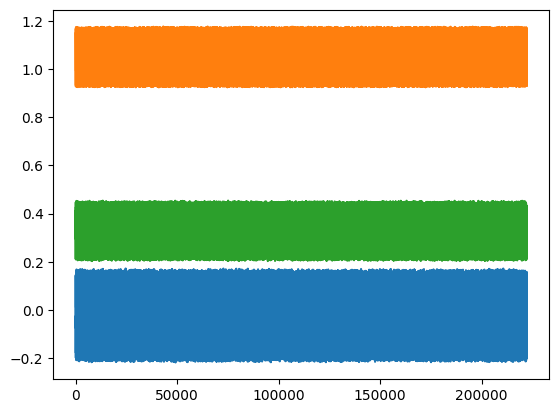

In [4]:
# get min max of grip_pos
grip_pos_min = grip_pos.min()
grip_pos_max = grip_pos.max()
action_min = action.min()
action_max = action.max()

# reshape action_min from (3, 1) to (3, )
action_min = action_min.values.reshape(3, )
action_max = action_max.values.reshape(3, )

print("grip_pos_min: ", grip_pos_min)
print("grip_pos_max: ", grip_pos_max)
print("action_min: ", action_min)
print("action_max: ", action_max)

import numpy as np

# generate random grip_pos 
grip_pos_random = np.random.uniform(grip_pos_min, grip_pos_max, size=(222222, 3))
grip_pos_random = pd.DataFrame(grip_pos_random)

# generate random action
action_random = np.random.uniform(action_min, action_max, size=(222222, 3))
action_random = pd.DataFrame(action_random).rename(columns={0: 3, 1: 4, 2: 5})

# predict the next grip_pos
grip_pos_next = reg1.predict(grip_pos_random.join(action_random))

# plot grip_pos_next
fig = plt.figure()
plt.plot(grip_pos_next, label='grip_pos_next')


## 5. Generate more data for the target position

target_pos_min:  0   -0.12680
1    0.89709
2    0.29401
dtype: float64
target_pos_max:  0    0.128536
1    1.206737
2    0.555039
dtype: float64
target_rel_vel_min:  3   -0.455992
4   -1.274353
5   -0.323028
dtype: float64
target_rel_vel_max:  3    0.423860
4    0.817082
5    0.428433
dtype: float64


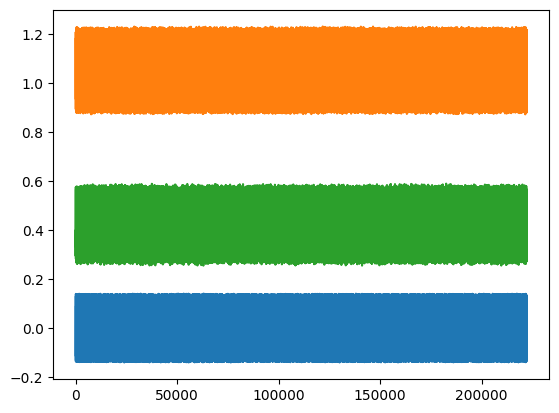

In [5]:
target_pos_min = target_pos.min()
target_pos_max = target_pos.max()
target_rel_vel_min = target_rel_vel.min()
target_rel_vel_max = target_rel_vel.max()

print("target_pos_min: ", target_pos_min)
print("target_pos_max: ", target_pos_max)
print("target_rel_vel_min: ", target_rel_vel_min)
print("target_rel_vel_max: ", target_rel_vel_max)

# generate random target_pos
target_pos_random = np.random.uniform(target_pos_min, target_pos_max, (222222, 3))
target_pos_random = pd.DataFrame(target_pos_random)

# generate random target_rel_vel
target_rel_vel_random = np.random.uniform(target_rel_vel_min, target_rel_vel_max, (222222, 3))
target_rel_vel_random = pd.DataFrame(target_rel_vel_random).rename(columns={0: 3, 1: 4, 2: 5})

# predict the next target_pos
target_pos_next_pred = reg2.predict(target_pos_random.join(target_rel_vel_random))
pred = target_pos_next_pred

# plot the prediction
fig = plt.figure()
plt.plot(pred, label='target_pos_next_pred')


## 6. Combine the generated features to make a new dataset

In [6]:
grip_pos_random = grip_pos_random.rename(columns={0: 0, 1: 1, 2: 2}).reset_index(drop=True)
target_pos_random = target_pos_random.rename(columns={0: 3, 1: 4, 2: 5}).reset_index(drop=True)
delta_pos = target_pos_random.rename(columns={3: 0, 4: 1, 5: 2}) - grip_pos_random
delta_pos = delta_pos.rename(columns={0: 6, 1: 7, 2: 8}).reset_index(drop=True)
target_rel_vel_random = target_rel_vel_random.rename(columns={3: 9, 4: 10, 5: 11}).reset_index(drop=True)
achieved_goal = grip_pos_random.rename(columns={0: 12, 1: 13, 2: 14})
goal = target_pos_random.rename(columns={3: 15, 4: 16, 5: 17})
action = action_random.rename(columns={3: 18, 4: 19, 5: 20})
grip_pos_next = pd.DataFrame(grip_pos_next).rename(columns={0: 22, 1: 23, 2: 24}).reset_index(drop=True)
target_pos_random_next = pd.DataFrame(target_pos_next_pred).rename(columns={0: 25, 1: 26, 2: 27}).reset_index(drop=True)
delta_pos_next = target_pos_random_next.rename(columns={25: 0, 26: 1, 27: 2}) - grip_pos_next.rename(columns={22: 0, 23: 1, 24: 2})
delta_pos_next = delta_pos_next.rename(columns={0: 28, 1: 29, 2: 30}).reset_index(drop=True)
target_rel_vel_random_next = target_rel_vel_random.rename(columns={3: 31, 4: 32, 5: 33}).reset_index(drop=True)
achieved_goal_next = grip_pos_next.rename(columns={22: 34, 23: 35, 24: 36})
REWARD_SCALE=10.0
reward = pd.DataFrame(-np.linalg.norm(delta_pos_next.to_numpy(), axis=-1)/REWARD_SCALE).rename(columns={0: 21})

# concat all the data
new_data = pd.concat([grip_pos_random, target_pos_random, delta_pos, target_rel_vel_random, achieved_goal, goal, action, reward, grip_pos_next, target_pos_random_next, delta_pos_next, target_rel_vel_random_next, achieved_goal_next, target_pos_random_next], axis=1)
new_data = new_data.reset_index(drop=True).to_numpy()

# remove original calculated distance
old_data = df.reset_index(drop=True).to_numpy()
old_data = np.delete(old_data, [40, 41], axis=1)
# concat new data and old data
new_data = np.concatenate((old_data, new_data), axis=0)
# export to csv
np.savetxt("./data/gen_data.csv", new_data, delimiter=",")

## 7. Train the original model with the new dataset

First, specify the path to the model file, and select if HER sampler is used or not.

In [7]:
model_path = 'saved_models/UnderwaterEnv/model_default_epoch1_2023-08-28-07-33-54.pt'
her_used = True

Define neccessary functions for the training

In [8]:
from torch.utils.tensorboard import SummaryWriter
from mpi_utils.normalizer import normalizer
import torch
from rl_modules.models import actor, critic
from mpi_utils.mpi_utils import sync_networks, sync_grads
from her_modules.her import her_sampler
from rl_modules.replay_buffer import replay_buffer

REWARD_SCALE = 10.0

def _goal_distance(goal_a, goal_b):
    assert goal_a.shape == goal_b.shape
    return np.linalg.norm(goal_a - goal_b, axis=-1)

def compute_reward(achieved_goal, desired_goal, info=None, reward_type="dense", max_reward=1.0):
    distance = _goal_distance(achieved_goal, desired_goal)
    reward = -distance.astype(np.float32)/REWARD_SCALE
    return reward
    
def _preproc_og(o, g):
    o = np.clip(o, -200, 200)
    g = np.clip(g, -200, 200)
    return o, g
    
def _update_network(transitions, 
                    o_norm_, 
                    g_norm_, 
                    actor_optim, 
                    critic_optim, 
                    actor_network, 
                    critic_network, 
                    i,
                    cuda=False):
    # pre-process the observation and goal
    o, o_next, g, g_next = transitions['obs'], transitions['obs_next'], transitions['g'], transitions['g_next']
    transitions['obs'], transitions['g'] = _preproc_og(o, g)
    transitions['obs_next'], transitions['g_next'] = _preproc_og(o_next, g_next)

    # start to do the update
    obs_norm = o_norm_.normalize(transitions['obs'])
    g_norm = g_norm_.normalize(transitions['g'])
    inputs_norm = np.concatenate([obs_norm, g_norm], axis=1)
    obs_next_norm = o_norm_.normalize(transitions['obs_next'])
    g_next_norm = g_norm_.normalize(transitions['g_next'])
    inputs_next_norm = np.concatenate([obs_next_norm, g_next_norm], axis=1)

    if i%20 == 0:
        print('---> with i = ', i)
        print('-> before normalization')
        print('obs: ', o[:4])
        print('g: ', g[:4])
        print('obs_next: ', o_next[:4])
        print('g_next: ', g_next[:4])
        print('-> after normalization')
        print('obs_norm: ', obs_norm[:4])
        print('g_norm: ', g_norm[:4])
        print('obs_next_norm: ', obs_next_norm[:4])
        print('g_next_norm: ', g_next_norm[:4])

    # transfer them into the tensor
    inputs_norm_tensor = torch.tensor(inputs_norm, dtype=torch.float32)
    inputs_next_norm_tensor = torch.tensor(inputs_next_norm, dtype=torch.float32)
    actions_tensor = torch.tensor(transitions['actions'], dtype=torch.float32)
    r_tensor = torch.tensor(transitions['r'], dtype=torch.float32) 

    if cuda:
        inputs_norm_tensor = inputs_norm_tensor.cuda()
        inputs_next_norm_tensor = inputs_next_norm_tensor.cuda()
        actions_tensor = actions_tensor.cuda()
        r_tensor = r_tensor.cuda()

    # calculate the target Q value function
    with torch.no_grad():
        gamma = 0.98
        target_q_value = r_tensor
        target_q_value = target_q_value.detach()

        # clip the q value
        clip_return = 1 / (1 - gamma)
        target_q_value = torch.clamp(target_q_value, -clip_return, 0)

    # the q loss
    real_q_value = critic_network(inputs_norm_tensor, actions_tensor)
    critic_loss = (target_q_value - real_q_value).pow(2).mean()

    if i%20 == 0:
        print('target_q_value  (r_tensor): ', r_tensor[:4], ', real_q_value: ', real_q_value[:4])

    # the actor loss
    actions_real = actor_network(inputs_norm_tensor)
    actor_loss = -critic_network(inputs_norm_tensor, actions_real).mean()

    if i%20 == 0:
        print('actions_real: ', actions_real[:4])

    # start to update the network
    actor_optim.zero_grad()
    actor_loss.backward()
    sync_grads(actor_network)
    actor_optim.step()

    # update the critic_network
    critic_optim.zero_grad()
    critic_loss.backward()
    sync_grads(critic_network)
    critic_optim.step()

    # print('actor_loss: ', actor_loss.item(), 'critic_loss: ', critic_loss.item(), end='\r')
    return actor_loss.item(), critic_loss.item()

# update the normalizer
def _update_normalizer(transitions, o_norm, g_norm):
    mb_obs, mb_ag, mb_g, mb_actions, mb_rewards, mb_obs_next, mb_ag_next, mb_g_next = transitions

    # create the new buffer to store them
    transitions = {'obs': mb_obs, 
                    'ag': mb_ag,
                    'g': mb_g, 
                    'actions': mb_actions, 
                    'obs_next': mb_obs_next,
                    'ag_next': mb_ag_next,
                    'g_next': mb_g_next,
                    'r': mb_rewards
                    }
    
    obs, g = transitions['obs'], transitions['g']
    obs_next, g_next = transitions['obs_next'], transitions['g_next']

    # pre process the obs and g
    transitions['obs'], transitions['g'] = _preproc_og(obs, g)

    # pre process the obs_next and g_next
    transitions['obs_next'], transitions['g_next'] = _preproc_og(obs_next, g_next)

    # update
    o_norm.update(transitions['obs'])
    g_norm.update(transitions['g'])
    o_norm.update(transitions['obs_next'])
    g_norm.update(transitions['g_next'])

    # recompute the stats
    o_norm.recompute_stats()
    g_norm.recompute_stats()

def _soft_update_target_network(target, source, polyak):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_((1 - polyak) * param.data + polyak * target_param.data)

def sample_her_transitions(transitions, replay_k):
    future_p = 1 - (1. / (1 + replay_k))
    rollout_batch_size = transitions['actions'].shape[0]

    # her idx
    her_indexes = np.where(np.random.uniform(size=rollout_batch_size) < future_p)

    # replace goal with achieved goal
    future_ag = transitions['ag'][her_indexes]
    transitions['g'][her_indexes] = future_ag
    transitions['g_next'][her_indexes] = future_ag

    # to get the params to re-compute reward
    transitions['r'] = np.expand_dims(compute_reward(transitions['ag_next'], transitions['g_next'], None), 1)
    transitions = {k: transitions[k].reshape(rollout_batch_size, *transitions[k].shape[1:]) for k in transitions.keys()}

    return transitions
    

/home/khiem/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Start the training

In [9]:
# nessary params for the training
env_params = {
    'obs': 12, # size of observation
    'goal': 3, # size of goal
    'action': 3, # size of action
    'action_max': 1, # max value of action
    'max_timesteps': 25 # max value of timesteps in one episode
}
learning_rate = 0.001
n_batches = 10000
replay_k = 2 # if the HER sampler is used
cuda = True
polyak = 0.0001 # since the generated data is much more than the original data, so we use a small polyak to overfit the data

# create the normalizer
o_norm = normalizer(size=env_params['obs'], default_clip_range=5)
g_norm = normalizer(size=env_params['goal'], default_clip_range=5)

# create the network
actor_network = actor(env_params)
critic_network = critic(env_params)

# load the model
o_mean, o_std, g_mean, g_std, actor_model, critic_model = torch.load(model_path, map_location=lambda storage, loc: storage)
o_norm.mean = o_mean
o_norm.std = o_std
g_norm.mean = g_mean
g_norm.std = g_std
actor_network.load_state_dict(actor_model)
critic_network.load_state_dict(critic_model)

# sync the network
sync_networks(actor_network)
sync_networks(critic_network)

# build up the target network
actor_target_network = actor(env_params)
critic_target_network = critic(env_params)

# if use gpu
actor_network.cuda()
critic_network.cuda()
actor_target_network.cuda()
critic_target_network.cuda()

# load the weights into the target networks
actor_target_network.load_state_dict(actor_network.state_dict())
critic_target_network.load_state_dict(critic_network.state_dict())

actor_optim = torch.optim.Adam(actor_network.parameters(), lr=learning_rate)
critic_optim = torch.optim.Adam(critic_network.parameters(), lr=learning_rate)

# obs, ag, g, actions, rewards, obs_next, ag_next
transitions = [new_data[:, 0:12], 
               new_data[:, 12:15], 
               new_data[:, 15:18], 
               new_data[:, 18:21], 
               new_data[:, 21:22], 
               new_data[:, 22:34], 
               new_data[:, 34:37],
               new_data[:, 37:40]]

# update the normalizer
_update_normalizer(transitions, o_norm, g_norm)

mb_obs, mb_ag, mb_g, mb_actions, mb_rewards, mb_obs_next, mb_ag_next, mb_g_next = transitions
transitions = {'obs': mb_obs, 
                'ag': mb_ag,
                'g': mb_g, 
                'actions': mb_actions, 
                'obs_next': mb_obs_next,
                'ag_next': mb_ag_next,
                'g_next': mb_g_next,
                'r': mb_rewards
                }

# her sampler
if her_used:
    transitions = sample_her_transitions(transitions, replay_k)

writer = SummaryWriter()
for i in range(n_batches):
    actor_loss, critic_loss = _update_network(transitions, 
                                              o_norm, 
                                              g_norm, 
                                              actor_optim, 
                                              critic_optim, 
                                              actor_network, 
                                              critic_network, 
                                              i,
                                              cuda=cuda)
    writer.add_scalar('actor_loss', actor_loss, i)
    writer.add_scalar('critic_loss', critic_loss, i)
    _soft_update_target_network(actor_target_network, actor_network, polyak)
    _soft_update_target_network(critic_target_network, critic_network, polyak)
    print('batch: ', i, ' actor_loss: ', actor_loss, ' critic_loss: ', critic_loss, end='\r')

2023-09-01 04:40:50.604509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-01 04:40:50.604562: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-01 04:40:52.764830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-01 04:40:52.765139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-01 04:40:52.765159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

---> with i =  0
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01]

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0034],
        [-0.0057],
        [-0.0031],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.9973,  0.6865, -0.9963],
        [-0.9991,  0.4591, -0.9986],
        [-0.9962,  0.7073, -0.9948],
        [-0.9905,  0.1123, -0.9945]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  60_loss:  0.005626528989523649  critic_loss:  6.793118518544361e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e

---> with i =  100loss:  0.006525109987705946  critic_loss:  4.581554821925238e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00 

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0019],
        [ 0.0024],
        [-0.0009],
        [-0.0115]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.4160, -0.9268, -0.1185],
        [-0.7268, -0.9907,  0.2269],
        [-0.3619, -0.9016, -0.0215],
        [-0.1382, -0.9498, -0.8364]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  160_loss:  0.005454080179333687  critic_loss:  3.0178867746144533e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  200_loss:  0.004943394102156162  critic_loss:  2.3610205971635878e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0029],
        [-0.0017],
        [-0.0028],
        [-0.0103]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 7.6421e-01, -9.8277e-01,  4.2360e-01],
        [-1.0096e-04, -9.9476e-01, -1.9664e-01],
        [ 6.8185e-01, -9.8125e-01,  4.1570e-01],
        [ 9.8052e-01, -9.8167e-01,  4.9394e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  260_loss:  0.005005102138966322  critic_loss:  1.7123691577580757e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-

---> with i =  300_loss:  0.005089513957500458  critic_loss:  1.4067464690015186e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0018],
        [-0.0016],
        [-0.0021],
        [-0.0127]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.3919, -0.9243,  0.3890],
        [ 0.5297, -0.2866,  0.2008],
        [ 0.3159, -0.8787,  0.4134],
        [ 0.9271, -0.9821,  0.0704]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  360_loss:  0.005699110683053732  critic_loss:  1.0812458640430123e-055
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  400_loss:  0.005739112850278616  critic_loss:  9.090658750210423e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0019],
        [-0.0022],
        [-0.0018],
        [-0.0136]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.4762, -0.3660,  0.2698],
        [ 0.5678,  0.5518,  0.1028],
        [ 0.3103, -0.1999,  0.2702],
        [-0.2217,  0.9362,  0.8180]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  460_loss:  0.005243086256086826  critic_loss:  7.258702225954039e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060

---> with i =  500_loss:  0.006010899785906076  critic_loss:  6.164989827084355e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0014],
        [-0.0008],
        [-0.0005],
        [-0.0122]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.5754, -0.2896, -0.0479],
        [ 0.5776,  0.5101, -0.0245],
        [ 0.4248, -0.2293, -0.0469],
        [-0.7260,  0.9993,  0.9864]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  560_loss:  0.006067757960408926  critic_loss:  4.927097506879363e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060

---> with i =  600_loss:  0.005698991473764181  critic_loss:  4.356898898549844e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0007],
        [-0.0005],
        [-0.0119]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.6241, -0.1812, -0.0384],
        [ 0.5243,  0.5043,  0.1962],
        [ 0.5072, -0.0301, -0.0546],
        [-0.5407,  0.9997,  0.9950]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  660_loss:  0.006647451315075159  critic_loss:  4.015667400381062e-0666
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  700_loss:  0.005477864295244217  critic_loss:  3.6988064948673127e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0009],
        [-0.0005],
        [-0.0115]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.5310,  0.1984,  0.0464],
        [ 0.4605,  0.1990,  0.4393],
        [ 0.4878,  0.2138,  0.0748],
        [-0.5550,  0.9997,  0.9978]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  760_loss:  0.006322456523776054  critic_loss:  2.921466602856526e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060

---> with i =  800_loss:  0.006042074877768755  critic_loss:  2.6738794076663908e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0002],
        [-0.0012],
        [-0.0002],
        [-0.0115]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.2056,  0.4713, -0.0258],
        [ 0.3355, -0.2979,  0.4456],
        [ 0.2486,  0.3855,  0.0933],
        [-0.5172,  0.9995,  0.9987]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  860_loss:  0.0063059283420443535  critic_loss:  2.3938055164762773e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  900_loss:  0.006318137515336275  critic_loss:  2.2112010356067913e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-2.0739e-04],
        [-1.3078e-03],
        [-6.7396e-05],
        [-1.1422e-02]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.1064,  0.5291,  0.1112],
        [ 0.4337, -0.0645,  0.4797],
        [ 0.2695,  0.4343,  0.2739],
        [-0.5006,  0.9992,  0.9991]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  960_loss:  0.006542854011058807  critic_loss:  2.081500497297384e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-0

---> with i =  1000loss:  0.006334624718874693  critic_loss:  1.8914322481577983e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0002],
        [-0.0006],
        [ 0.0001],
        [-0.0106]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.1689,  0.4034,  0.0758],
        [ 0.4907, -0.0012,  0.3697],
        [ 0.3186,  0.3257,  0.2403],
        [-0.5452,  0.9989,  0.9990]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1060_loss:  0.0067549156956374645  critic_loss:  2.0034831322846003e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1100_loss:  0.006459731608629227  critic_loss:  1.6806902749522123e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0005],
        [-0.0015],
        [-0.0003],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0310,  0.5951,  0.1664],
        [ 0.3868,  0.2798,  0.3457],
        [ 0.1143,  0.6013,  0.2890],
        [-0.5073,  0.9977,  0.9993]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1160_loss:  0.006383594125509262  critic_loss:  1.5309991567846737e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  1200_loss:  0.005624542012810707  critic_loss:  2.1448613551910967e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0005],
        [-0.0014],
        [-0.0002],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0727,  0.6188,  0.1448],
        [ 0.3708,  0.2423,  0.3300],
        [ 0.0804,  0.6248,  0.2571],
        [-0.4277,  0.9959,  0.9994]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1260_loss:  0.006292873993515968  critic_loss:  1.379389914291096e-0666
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1300_loss:  0.006639330647885799  critic_loss:  1.3701342140848283e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[ 0.0002],
        [-0.0006],
        [ 0.0004],
        [-0.0103]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0571,  0.6218,  0.1835],
        [ 0.4007,  0.2029,  0.3358],
        [ 0.1088,  0.6342,  0.2826],
        [-0.1692,  0.9926,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1360_loss:  0.006913770921528339  critic_loss:  1.4865551065668114e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1400_loss:  0.006432748399674892  critic_loss:  1.1990003940809402e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0017],
        [-0.0004],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1196,  0.5907,  0.1322],
        [ 0.3417,  0.1408,  0.2447],
        [ 0.0438,  0.5798,  0.2181],
        [ 0.0026,  0.9735,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1460_loss:  0.00781475380063057  critic_loss:  3.373858135091723e-06665
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1500_loss:  0.006617783568799496  critic_loss:  1.1395615047149477e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0015],
        [-0.0004],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1569,  0.5829,  0.1224],
        [ 0.3037,  0.2035,  0.1929],
        [-0.0077,  0.5640,  0.1933],
        [ 0.2326,  0.9562,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1560_loss:  0.006475613918155432  critic_loss:  1.0219345085715759e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1600_loss:  0.0066285571083426476  critic_loss:  1.1414578011681442e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0015],
        [-0.0004],
        [-0.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1318,  0.5495,  0.1179],
        [ 0.3196,  0.2010,  0.1701],
        [ 0.0099,  0.5311,  0.1923],
        [ 0.3407,  0.9243,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1660_loss:  0.00636008707806468  critic_loss:  9.491433843322739e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  1700_loss:  0.006801780313253403  critic_loss:  1.0661318583515822e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0016],
        [-0.0006],
        [-0.0114]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1340,  0.5358,  0.1155],
        [ 0.2802,  0.1479,  0.1022],
        [-0.0033,  0.5141,  0.1751],
        [ 0.3829,  0.9132,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1760_loss:  0.007115818560123444  critic_loss:  1.381167976433062e-0666
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1800_loss:  0.006705967243760824  critic_loss:  9.072812190424884e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0016],
        [-0.0007],
        [-0.0114]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1231,  0.4608,  0.1229],
        [ 0.2277, -0.0247,  0.0727],
        [ 0.0081,  0.4426,  0.1831],
        [ 0.3389,  0.8735,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1860_loss:  0.006182058714330196  critic_loss:  8.940779707700131e-0776
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  1900_loss:  0.007057521026581526  critic_loss:  1.2299061609155615e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0014],
        [-0.0005],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-1.1778e-01,  4.7593e-01,  1.0104e-01],
        [ 2.2847e-01,  5.8441e-04,  2.2960e-02],
        [ 7.1174e-03,  4.8652e-01,  1.7054e-01],
        [ 3.6579e-01,  8.5463e-01,  9.9969e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  1960_loss:  0.00638976925984025  critic_loss:  7.561895927210571e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-0

---> with i =  2000_loss:  0.006283867638558149  critic_loss:  8.310116754728369e-0706
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0012],
        [-0.0004],
        [-0.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0965,  0.4622,  0.1093],
        [ 0.2317, -0.0108,  0.0201],
        [ 0.0250,  0.5076,  0.1886],
        [ 0.3846,  0.8521,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2060_loss:  0.006442204117774963  critic_loss:  7.055329547256406e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  2100_loss:  0.005668462719768286  critic_loss:  1.4579046592189115e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0011],
        [-0.0004],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0984,  0.4545,  0.1013],
        [ 0.1963, -0.0265, -0.0146],
        [ 0.0193,  0.5037,  0.1740],
        [ 0.3601,  0.8453,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2160_loss:  0.006371646653860807  critic_loss:  6.695901220155065e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  2200_loss:  0.005441319663077593  critic_loss:  1.9837309537251713e-06
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0010],
        [-0.0004],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0868,  0.4544,  0.1013],
        [ 0.1875, -0.0332, -0.0210],
        [ 0.0241,  0.5214,  0.1707],
        [ 0.3766,  0.8624,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2260_loss:  0.006404684856534004  critic_loss:  6.319931458165229e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  2300_loss:  0.006509779486805201  critic_loss:  6.054737582417147e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0009],
        [-0.0003],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[0.0052, 0.4887, 0.1793],
        [0.2215, 0.0145, 0.0284],
        [0.0902, 0.5458, 0.2307],
        [0.3275, 0.8387, 0.9996]], device='cuda:0', grad_fn=<SliceBackward0>)
---> with i =  2360_loss:  0.00624940125271678  critic_loss:  6.504089924419532e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+

---> with i =  2400_loss:  0.006542815361171961  critic_loss:  5.750735567744414e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0009],
        [-0.0004],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0041,  0.4920,  0.1743],
        [ 0.2130,  0.0119,  0.0242],
        [ 0.0787,  0.5457,  0.2249],
        [ 0.3112,  0.8139,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2460_loss:  0.006459806580096483  critic_loss:  5.613415510197228e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  2500_loss:  0.0063365548849105835  critic_loss:  5.531766191779752e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0009],
        [-0.0004],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0441,  0.4929,  0.1389],
        [ 0.1904,  0.0512,  0.0047],
        [ 0.0402,  0.5526,  0.1964],
        [ 0.2949,  0.8022,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2560_loss:  0.006648784037679434  critic_loss:  5.623074912364245e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  2600_loss:  0.007062986493110657  critic_loss:  8.850224162415543e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+00

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0012],
        [-0.0008],
        [-0.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0782,  0.4985,  0.1097],
        [ 0.1579, -0.0092, -0.0274],
        [ 0.0062,  0.5651,  0.1687],
        [ 0.2688,  0.7312,  0.9995]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2660_loss:  0.0063079041428864  critic_loss:  5.165437073628709e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060

---> with i =  2700_loss:  0.005952819716185331  critic_loss:  8.384611192013836e-0706
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0008],
        [-0.0004],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0797,  0.5482,  0.1086],
        [ 0.1397,  0.0342, -0.0369],
        [ 0.0022,  0.6114,  0.1683],
        [ 0.2270,  0.7046,  0.9995]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2760_loss:  0.006249268539249897  critic_loss:  5.085290695205913e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  2800_loss:  0.006770498119294643  critic_loss:  5.691700835086522e-0776
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0009],
        [-0.0006],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0553,  0.5604,  0.1145],
        [ 0.1458,  0.0620, -0.0347],
        [ 0.0217,  0.6359,  0.1788],
        [ 0.2196,  0.6599,  0.9994]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2860_loss:  0.006449661683291197  critic_loss:  4.372013790998608e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  2900_loss:  0.007791868876665831  critic_loss:  2.5737431315064896e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0009],
        [-0.0007],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0280,  0.5630,  0.1551],
        [ 0.2208,  0.1176,  0.0830],
        [ 0.0453,  0.6179,  0.2080],
        [ 0.4384,  0.8545,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  2960_loss:  0.0063940295949578285  critic_loss:  4.4884149019708275e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  3000_loss:  0.006445320323109627  critic_loss:  4.1755436086532427e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0009],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0210,  0.5993,  0.1313],
        [ 0.1508,  0.2032, -0.0102],
        [ 0.0477,  0.7020,  0.1895],
        [ 0.1889,  0.5692,  0.9993]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3060_loss:  0.006446714047342539  critic_loss:  3.941159150144813e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  3100_loss:  0.006298385094851255  critic_loss:  4.023784470064129e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0014],
        [-0.0011],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[0.0360, 0.5116, 0.1939],
        [0.1683, 0.2420, 0.0639],
        [0.0784, 0.5819, 0.2322],
        [0.1782, 0.7631, 0.9994]], device='cuda:0', grad_fn=<SliceBackward0>)
---> with i =  3160_loss:  0.006407257169485092  critic_loss:  4.0137331325240666e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e

---> with i =  3200_loss:  0.006410615053027868  critic_loss:  3.7162314470151614e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0009],
        [-0.0007],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-2.5054e-02,  6.3597e-01,  1.4744e-01],
        [ 8.0609e-02,  3.3540e-01, -2.8552e-04],
        [ 3.0907e-02,  7.4298e-01,  1.8794e-01],
        [ 1.1967e-01,  5.8367e-01,  9.9922e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3260_loss:  0.006438926327973604  critic_loss:  3.5147238008903514e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e

---> with i =  3300_loss:  0.005719837266951799  critic_loss:  1.0962218084387132e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0008],
        [-0.0006],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[5.5001e-04, 6.8770e-01, 1.6884e-01],
        [9.4414e-02, 5.0728e-01, 2.0747e-02],
        [4.2469e-02, 7.7288e-01, 1.9666e-01],
        [1.2548e-01, 6.8694e-01, 9.9928e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3360_loss:  0.00643895473331213  critic_loss:  3.398692172140727e-07-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230

---> with i =  3400_loss:  0.006373010575771332  critic_loss:  3.292840915491979e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0012],
        [-0.0010],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[0.0587, 0.5301, 0.1875],
        [0.1103, 0.2747, 0.0241],
        [0.0844, 0.6294, 0.2108],
        [0.0904, 0.7021, 0.9992]], device='cuda:0', grad_fn=<SliceBackward0>)
---> with i =  3460_loss:  0.006457306910306215  critic_loss:  3.3099340157605184e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e

---> with i =  3500_loss:  0.0064470493234694  critic_loss:  3.138655699785886e-07077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0009],
        [-0.0009],
        [-0.0104]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0813,  0.3129,  0.1733],
        [ 0.1083, -0.0473,  0.0017],
        [ 0.0969,  0.4454,  0.1882],
        [ 0.0554,  0.7813,  0.9991]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3560_loss:  0.006212364882230759  critic_loss:  3.823012377779378e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  3600_loss:  0.0064286342822015285  critic_loss:  3.012480931374739e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0006],
        [-0.0003],
        [-0.0002],
        [-0.0103]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0168,  0.7184,  0.1631],
        [ 0.0279,  0.5388, -0.0160],
        [ 0.0399,  0.8116,  0.1711],
        [ 0.0322,  0.7877,  0.9990]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3660_loss:  0.0060472646728158  critic_loss:  5.859938596586289e-07-076
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  3700_loss:  0.006494852248579264  critic_loss:  3.025191972483299e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0008],
        [-0.0006],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0155,  0.7248,  0.1613],
        [ 0.0192,  0.5348, -0.0149],
        [ 0.0354,  0.8127,  0.1668],
        [-0.0116,  0.8378,  0.9988]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3760_loss:  0.007779555860906839  critic_loss:  2.294352043463732e-0667
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  3800_loss:  0.006166481412947178  critic_loss:  3.447805738687748e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0008],
        [-0.0006],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0383,  0.7241,  0.1473],
        [ 0.0445,  0.5391, -0.0241],
        [ 0.0567,  0.8172,  0.1522],
        [ 0.0045,  0.8797,  0.9986]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3860_loss:  0.005547458305954933  critic_loss:  1.010395635603345e-067
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  3900_loss:  0.006583346053957939  critic_loss:  3.104736379100359e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0008],
        [-0.0006],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0208,  0.7194,  0.1443],
        [ 0.0329,  0.5704, -0.0077],
        [ 0.0396,  0.8141,  0.1461],
        [-0.0197,  0.9107,  0.9985]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  3960_loss:  0.006489900406450033  critic_loss:  2.6474424430489307e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4000_loss:  0.00632321834564209  critic_loss:  2.692881651000789e-07077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0009],
        [-0.0007],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0350,  0.7067,  0.1259],
        [ 0.0469,  0.5767, -0.0121],
        [ 0.0559,  0.8087,  0.1319],
        [ 0.0045,  0.9213,  0.9982]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4060_loss:  0.005044811870902777  critic_loss:  2.1454911802720744e-066
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4100_loss:  0.006168230436742306  critic_loss:  2.880832710161485e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0009],
        [-0.0007],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0362,  0.7165,  0.1100],
        [ 0.0346,  0.5775, -0.0286],
        [ 0.0573,  0.8160,  0.1202],
        [-0.0010,  0.9291,  0.9979]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4160_loss:  0.006510394159704447  critic_loss:  4.336435210916534e-0766
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4200_loss:  0.006393358111381531  critic_loss:  2.478706164765754e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0008],
        [-0.0006],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0413,  0.7000,  0.1156],
        [ 0.0470,  0.5817, -0.0115],
        [ 0.0605,  0.8038,  0.1251],
        [ 0.0081,  0.9577,  0.9976]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4260_loss:  0.0063562714494764805  critic_loss:  2.2031160540336714e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4300_loss:  0.006194651126861572  critic_loss:  3.1618523621546046e-076
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0033,  0.5826,  0.0764],
        [ 0.0273,  0.5918, -0.0147],
        [ 0.0262,  0.7400,  0.0887],
        [-0.0096,  0.9632,  0.9973]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4360_loss:  0.006411528680473566  critic_loss:  2.1866101462819643e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4400_loss:  0.0069167534820735455  critic_loss:  5.640462745759578e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0009],
        [-0.0005],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-6.6558e-02,  1.4456e-01,  5.4263e-04],
        [-6.8259e-03,  3.7218e-01, -4.8472e-02],
        [-3.5653e-02,  4.5368e-01,  2.6802e-02],
        [ 7.6425e-03,  9.6788e-01,  9.9696e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4460_loss:  0.0062235938385128975  critic_loss:  2.1830435059655429e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e

---> with i =  4500_loss:  0.005292321555316448  critic_loss:  1.3618747516375151e-067
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0004],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0129,  0.5084,  0.0512],
        [ 0.0221,  0.5818, -0.0126],
        [ 0.0074,  0.6926,  0.0643],
        [-0.0059,  0.9650,  0.9967]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4560_loss:  0.0063531952910125256  critic_loss:  1.9559549002678978e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4600_loss:  0.005652962252497673  critic_loss:  7.984557441886864e-076
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0009],
        [-0.0007],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0042,  0.5935,  0.0683],
        [ 0.0166,  0.5600, -0.0102],
        [ 0.0191,  0.7314,  0.0759],
        [-0.0313,  0.9530,  0.9965]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4660_loss:  0.0065337358973920345  critic_loss:  2.348179037880982e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  4700_loss:  0.0066167498007416725  critic_loss:  2.7266187885288673e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0002],
        [ 0.0004],
        [ 0.0003],
        [-0.0096]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[ 0.0197,  0.6453,  0.0817],
        [ 0.0196,  0.5563, -0.0075],
        [ 0.0282,  0.7440,  0.0828],
        [-0.0171,  0.9532,  0.9962]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4760_loss:  0.006074007134884596  critic_loss:  2.843004835995089e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  4800_loss:  0.006157800555229187  critic_loss:  2.0071180983904924e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0014],
        [-0.0010],
        [-0.0008],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1078, -0.2494, -0.0461],
        [-0.0425,  0.2012, -0.0693],
        [-0.0719,  0.0725, -0.0190],
        [-0.0041,  0.9678,  0.9959]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4860_loss:  0.006267423275858164  critic_loss:  1.763737600413151e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  4900_loss:  0.005941355600953102  critic_loss:  3.473060132819228e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0009],
        [-0.0008],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0031,  0.4084,  0.0317],
        [ 0.0025,  0.4007, -0.0452],
        [ 0.0130,  0.5594,  0.0413],
        [ 0.0088,  0.9478,  0.9956]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  4960_loss:  0.006828616373240948  critic_loss:  4.505819504174724e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  5000_loss:  0.005945815239101648  critic_loss:  3.0763001745981455e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0010],
        [-0.0008],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-1.6988e-02,  4.1973e-01,  2.4209e-02],
        [ 5.4982e-04,  5.0020e-01, -2.6400e-02],
        [ 1.2014e-03,  5.7226e-01,  3.6339e-02],
        [-1.3879e-02,  9.5245e-01,  9.9531e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5060_loss:  0.006697041913866997  critic_loss:  3.2830419627316587e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e

---> with i =  5100_loss:  0.006162841804325581  critic_loss:  1.7996474355186365e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0007],
        [-0.0005],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0537,  0.1693, -0.0129],
        [-0.0199,  0.4188, -0.0451],
        [-0.0283,  0.3704,  0.0053],
        [-0.0014,  0.9598,  0.9953]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5160_loss:  0.006162230856716633  critic_loss:  1.756818051035225e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5200_loss:  0.005992746911942959  critic_loss:  3.31126273067639e-07077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0006],
        [-0.0005],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0143,  0.4210,  0.0246],
        [-0.0249,  0.3517, -0.0457],
        [-0.0057,  0.5047,  0.0257],
        [-0.0135,  0.9529,  0.9953]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5260_loss:  0.006991430651396513  critic_loss:  6.700364565404016e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5300_loss:  0.006291935220360756  critic_loss:  1.486317557919392e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0005],
        [-0.0005],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0714, -0.0730, -0.0265],
        [-0.0478,  0.1404, -0.0662],
        [-0.0424,  0.1859, -0.0090],
        [-0.0022,  0.9476,  0.9957]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5360_loss:  0.005750517826527357  critic_loss:  4.7230315658453037e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5400_loss:  0.006826050113886595  critic_loss:  4.526567636276013e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0004],
        [-0.0106]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0976, -0.1588, -0.0543],
        [-0.0538,  0.1718, -0.0619],
        [-0.0715,  0.0635, -0.0314],
        [-0.0120,  0.9550,  0.9954]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5460_loss:  0.006252481136471033  critic_loss:  1.483433607063489e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5500_loss:  0.006233115214854479  critic_loss:  1.382155403462093e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0006],
        [-0.0008],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1708, -0.7338, -0.1043],
        [-0.1064, -0.2045, -0.1024],
        [-0.1517, -0.6008, -0.0894],
        [-0.0156,  0.9663,  0.9961]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5560_loss:  0.006188633386045694  critic_loss:  1.5129447206163604e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  5600_loss:  0.006397611927241087  critic_loss:  1.4630317934916093e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1181, -0.2904, -0.0696],
        [-0.0700,  0.0990, -0.0737],
        [-0.0935, -0.0833, -0.0522],
        [-0.0319,  0.9645,  0.9961]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5660_loss:  0.006121939048171043  critic_loss:  1.6029100891046255e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5700_loss:  0.00606195442378521  critic_loss:  1.7081006831176637e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0006],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0713, -0.0058, -0.0304],
        [-0.0466,  0.1799, -0.0501],
        [-0.0522,  0.1391, -0.0194],
        [-0.0320,  0.9568,  0.9966]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5760_loss:  0.006350903771817684  critic_loss:  1.3238465612630534e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5800_loss:  0.006132693961262703  critic_loss:  1.743066349035871e-0776
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0004],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0429,  0.1534, -0.0150],
        [-0.0468,  0.1446, -0.0540],
        [-0.0337,  0.2263, -0.0121],
        [-0.0483,  0.9406,  0.9968]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5860_loss:  0.006584887858480215  critic_loss:  2.2453482984019502e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  5900_loss:  0.008432704024016857  critic_loss:  5.0781127356458455e-067
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0006],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1317, -0.4518, -0.0838],
        [-0.0695, -0.0223, -0.0695],
        [-0.1033, -0.2492, -0.0642],
        [-0.0209,  0.9537,  0.9970]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  5960_loss:  0.006160690449178219  critic_loss:  1.3655518671384925e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6000_loss:  0.006232999265193939  critic_loss:  1.158151690106024e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0004],
        [-0.0007],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1991, -0.8457, -0.1236],
        [-0.1394, -0.4374, -0.1141],
        [-0.1786, -0.7418, -0.1106],
        [-0.0487,  0.9728,  0.9975]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6060_loss:  0.006136082578450441  critic_loss:  1.4366511891239497e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6100_loss:  0.006165029015392065  critic_loss:  1.1785307663103595e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0008],
        [-0.0008],
        [-0.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1561, -0.5589, -0.0959],
        [-0.0904, -0.0864, -0.0788],
        [-0.1321, -0.4169, -0.0828],
        [-0.0486,  0.9702,  0.9977]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6160_loss:  0.0062653436325490475  critic_loss:  1.1078739703407336e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6200_loss:  0.006075360346585512  critic_loss:  1.8169953364122193e-076
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0007],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0384,  0.1094, -0.0133],
        [-0.0323,  0.1737, -0.0323],
        [-0.0303,  0.1727, -0.0105],
        [-0.0155,  0.9555,  0.9980]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6260_loss:  0.0059065851382911205  critic_loss:  2.296071386354015e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6300_loss:  0.006305602379143238  critic_loss:  1.0759252688785637e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0008],
        [-0.0009],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1880, -0.8000, -0.1151],
        [-0.1091, -0.2742, -0.0896],
        [-0.1686, -0.6695, -0.1045],
        [-0.0210,  0.9756,  0.9982]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6360_loss:  0.006043212953954935  critic_loss:  1.5023233856936713e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6400_loss:  0.005419945809990168  critic_loss:  9.962785725292633e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0006],
        [-0.0007],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0443,  0.0691, -0.0217],
        [-0.0405,  0.1398, -0.0387],
        [-0.0372,  0.1234, -0.0194],
        [-0.0199,  0.9485,  0.9983]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6460_loss:  0.006270446814596653  critic_loss:  1.0034359831934125e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6500_loss:  0.0069029065780341625  critic_loss:  4.769374299939955e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0486,  0.0242, -0.0256],
        [-0.0442,  0.0802, -0.0432],
        [-0.0412,  0.0970, -0.0219],
        [-0.0417,  0.9513,  0.9984]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6560_loss:  0.006282080430537462  critic_loss:  9.938024447819771e-088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  6600_loss:  0.00590270571410656  critic_loss:  2.6376213213552546e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0007],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0417,  0.0277, -0.0165],
        [-0.0382,  0.1017, -0.0321],
        [-0.0368,  0.0771, -0.0153],
        [-0.0208,  0.9371,  0.9986]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6660_loss:  0.0059952326118946075  critic_loss:  2.0287036761601485e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6700_loss:  0.006239274982362986  critic_loss:  9.417780688636412e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0014],
        [-0.0010],
        [-0.0011],
        [-0.0114]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0770, -0.1555, -0.0455],
        [-0.0643, -0.0211, -0.0559],
        [-0.0678, -0.0842, -0.0419],
        [-0.0389,  0.9384,  0.9987]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6760_loss:  0.006337732542306185  critic_loss:  1.0349767620709827e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  6800_loss:  0.0059571280144155025  critic_loss:  1.7890049264224217e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0010],
        [-0.0010],
        [-0.0115]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.1954, -0.7975, -0.1143],
        [-0.1316, -0.3613, -0.0984],
        [-0.1861, -0.7035, -0.1114],
        [-0.0151,  0.9673,  0.9990]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6860_loss:  0.0063017141073942184  critic_loss:  9.665268407843541e-087
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  6900_loss:  0.0061201839707791805  critic_loss:  1.235206497085528e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0003],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0528,  0.0065, -0.0271],
        [-0.0541,  0.0468, -0.0419],
        [-0.0471,  0.0503, -0.0246],
        [-0.0355,  0.9257,  0.9990]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  6960_loss:  0.006185709498822689  critic_loss:  8.740810386598241e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7000_loss:  0.005948535166680813  critic_loss:  2.0341096274023585e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0013],
        [-0.0009],
        [-0.0009],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0504,  0.0133, -0.0317],
        [-0.0547,  0.0162, -0.0505],
        [-0.0451,  0.0525, -0.0296],
        [-0.0294,  0.9193,  0.9991]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7060_loss:  0.006516200955957174  critic_loss:  1.7521331585612643e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7100_loss:  0.006311800330877304  critic_loss:  9.709271608926429e-0807
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0003],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0495,  0.0161, -0.0295],
        [-0.0553,  0.0084, -0.0474],
        [-0.0444,  0.0484, -0.0268],
        [-0.0226,  0.9195,  0.9993]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7160_loss:  0.0064390674233436584  critic_loss:  1.3478916116582695e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7200_loss:  0.006258195731788874  critic_loss:  1.0107677184123531e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0474,  0.0201, -0.0308],
        [-0.0549,  0.0039, -0.0495],
        [-0.0442,  0.0364, -0.0297],
        [-0.0318,  0.9130,  0.9993]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7260_loss:  0.007198016624897718  critic_loss:  1.095545599127945e-0667
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7300_loss:  0.005958252586424351  critic_loss:  1.4557808469817246e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0007],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0478,  0.0256, -0.0273],
        [-0.0567,  0.0074, -0.0449],
        [-0.0452,  0.0449, -0.0266],
        [-0.0268,  0.9129,  0.9994]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7360_loss:  0.006243329960852861  critic_loss:  2.0219579255353892e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7400_loss:  0.006371287163347006  critic_loss:  1.1079912809464076e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0008],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0454,  0.0300, -0.0269],
        [-0.0542,  0.0117, -0.0441],
        [-0.0418,  0.0531, -0.0255],
        [-0.0287,  0.9373,  0.9995]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7460_loss:  0.006852411199361086  critic_loss:  4.913644033877063e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  7500_loss:  0.006016962230205536  critic_loss:  1.0822564888712805e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0006],
        [-0.0007],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0438,  0.0186, -0.0326],
        [-0.0547, -0.0085, -0.0515],
        [-0.0411,  0.0377, -0.0315],
        [-0.0095,  0.9412,  0.9995]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7560_loss:  0.005402343347668648  critic_loss:  8.063864811447274e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7600_loss:  0.005958593916147947  critic_loss:  1.297016325452205e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0004],
        [-0.0005],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0496,  0.0231, -0.0344],
        [-0.0649, -0.0301, -0.0554],
        [-0.0482,  0.0426, -0.0348],
        [-0.0241,  0.9065,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7660_loss:  0.006290663965046406  critic_loss:  8.235038961856844e-088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  7700_loss:  0.006440251134335995  critic_loss:  1.307124364302581e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0007],
        [-0.0008],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0496,  0.0235, -0.0347],
        [-0.0619, -0.0141, -0.0528],
        [-0.0478,  0.0384, -0.0344],
        [-0.0304,  0.9196,  0.9996]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7760_loss:  0.0068956888280808926  critic_loss:  6.023930154697155e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7800_loss:  0.0059435018338263035  critic_loss:  1.369531759110032e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0005],
        [-0.0007],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0487,  0.0326, -0.0329],
        [-0.0599, -0.0020, -0.0494],
        [-0.0470,  0.0442, -0.0328],
        [ 0.0019,  0.9433,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7860_loss:  0.006195446010679007  critic_loss:  6.777653993594868e-0887
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  7900_loss:  0.006090722978115082  critic_loss:  8.55669028965167e-0807
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0022],
        [-0.0016],
        [-0.0017],
        [-0.0121]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0430,  0.0368, -0.0309],
        [-0.0557, -0.0091, -0.0479],
        [-0.0424,  0.0396, -0.0318],
        [-0.0157,  0.9302,  0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  7960_loss:  0.006240233313292265  critic_loss:  7.89332759154604e-08077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8000_loss:  0.006260626949369907  critic_loss:  7.149986913645989e-088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0008],
        [-0.0009],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0575,  0.0116, -0.0418],
        [-0.0711, -0.0277, -0.0593],
        [-0.0578,  0.0147, -0.0429],
        [-0.0114,  0.9264,  0.9998]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8060_loss:  0.006424583029001951  critic_loss:  1.2723668874059513e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  8100_loss:  0.006534071173518896  critic_loss:  2.001744405788486e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0003],
        [-0.0004],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0500,  0.0200, -0.0343],
        [-0.0614, -0.0290, -0.0490],
        [-0.0496,  0.0251, -0.0356],
        [-0.0198,  0.8927,  0.9998]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8160_loss:  0.006435586605221033  critic_loss:  1.3335888127130602e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8200_loss:  0.00553624052554369  critic_loss:  5.240201517153764e-07077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-4.2287e-04],
        [ 1.7416e-04],
        [-3.2743e-05],
        [-1.0226e-02]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0470,  0.0305, -0.0319],
        [-0.0578, -0.0112, -0.0447],
        [-0.0477,  0.0300, -0.0339],
        [-0.0240,  0.8923,  0.9998]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8260_loss:  0.005922454874962568  critic_loss:  1.537001423912443e-0777
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e

---> with i =  8300_loss:  0.006324141751974821  critic_loss:  8.121255490323165e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0006],
        [-0.0008],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0558,  0.0099, -0.0425],
        [-0.0640, -0.0301, -0.0529],
        [-0.0562,  0.0100, -0.0426],
        [-0.0374,  0.9112,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8360_loss:  0.006272162776440382  critic_loss:  7.233396814854132e-0807
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8400_loss:  0.006128770299255848  critic_loss:  5.884693976554445e-088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0009],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0557,  0.0094, -0.0441],
        [-0.0710, -0.0437, -0.0576],
        [-0.0568,  0.0116, -0.0445],
        [-0.0226,  0.8745,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8460_loss:  0.006350863259285688  critic_loss:  9.430475955696238e-0807
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8500_loss:  0.0059692212380468845  critic_loss:  9.457589555950108e-08
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0008],
        [-0.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0511,  0.0160, -0.0370],
        [-0.0604, -0.0314, -0.0469],
        [-0.0517,  0.0168, -0.0390],
        [-0.0323,  0.8720,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8560_loss:  0.006366687826812267  critic_loss:  1.0212581003088417e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8600_loss:  0.006049178075045347  critic_loss:  7.024753756468272e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0008],
        [-0.0010],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0552,  0.0211, -0.0415],
        [-0.0673, -0.0184, -0.0519],
        [-0.0565,  0.0215, -0.0431],
        [-0.0286,  0.8806,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8660_loss:  0.0060739279724657536  critic_loss:  6.428992094242858e-087
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8700_loss:  0.006335497368127108  critic_loss:  8.463311473860813e-0887
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0016],
        [-0.0012],
        [-0.0014],
        [-0.0117]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0553,  0.0350, -0.0415],
        [-0.0620,  0.0049, -0.0473],
        [-0.0555,  0.0359, -0.0421],
        [-0.0474,  0.8990,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8760_loss:  0.0058193812146782875  critic_loss:  2.005018160389227e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  8800_loss:  0.006142075173556805  critic_loss:  5.3535501365331584e-08
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0473,  0.0267, -0.0334],
        [-0.0558, -0.0137, -0.0401],
        [-0.0474,  0.0296, -0.0353],
        [-0.0496,  0.8237,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8860_loss:  0.005544145591557026  critic_loss:  7.051786496958812e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  8900_loss:  0.006250611040741205  critic_loss:  6.621601045253556e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0468,  0.0248, -0.0315],
        [-0.0531, -0.0051, -0.0385],
        [-0.0471,  0.0306, -0.0340],
        [-0.0473,  0.8562,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  8960_loss:  0.0061234901659190655  critic_loss:  5.0282778829569e-08088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9000_loss:  0.005375377368181944  critic_loss:  6.773487939426559e-0778
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0003],
        [-0.0005],
        [-0.0108]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0542,  0.0132, -0.0394],
        [-0.0599, -0.0108, -0.0410],
        [-0.0550,  0.0175, -0.0418],
        [-0.0334,  0.7944,  0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9060_loss:  0.0060609253123402596  critic_loss:  5.915433476388898e-08
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  9100_loss:  0.00619107112288475  critic_loss:  5.096265809356737e-08088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0003],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0496,  0.0122, -0.0401],
        [-0.0583, -0.0256, -0.0445],
        [-0.0499,  0.0180, -0.0412],
        [-0.0153,  0.8065,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9160_loss:  0.006146444473415613  critic_loss:  4.765382755067549e-0887
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9200_loss:  0.005817125551402569  critic_loss:  1.8481867414266162e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0008],
        [-0.0003],
        [-0.0005],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0522,  0.0191, -0.0381],
        [-0.0571, -0.0119, -0.0397],
        [-0.0519,  0.0253, -0.0397],
        [-0.0267,  0.7046,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9260_loss:  0.005679106805473566  critic_loss:  2.7141186365042813e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9300_loss:  0.00675475038588047  critic_loss:  4.480468476231181e-07077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0014],
        [-0.0009],
        [-0.0010],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0495,  0.0233, -0.0364],
        [-0.0537, -0.0033, -0.0392],
        [-0.0496,  0.0279, -0.0388],
        [-0.0034,  0.6303,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9360_loss:  0.0059575280174613  critic_loss:  8.03697801643466e-0808077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9400_loss:  0.005646934732794762  critic_loss:  4.143640239817614e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0009],
        [-0.0005],
        [-0.0006],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0499,  0.0174, -0.0391],
        [-0.0534, -0.0054, -0.0429],
        [-0.0499,  0.0230, -0.0416],
        [ 0.0084,  0.5845,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9460_loss:  0.005939690861850977  critic_loss:  8.012522556555268e-088
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.1689106

---> with i =  9500_loss:  0.0063544088043272495  critic_loss:  1.0082149515255878e-07
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0010],
        [-0.0006],
        [-0.0007],
        [-0.0110]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0496,  0.0251, -0.0391],
        [-0.0530,  0.0035, -0.0398],
        [-0.0499,  0.0287, -0.0416],
        [ 0.0088,  0.5565,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9560_loss:  0.006483674980700016  critic_loss:  1.8966041182011395e-077
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9600_loss:  0.006226124707609415  critic_loss:  5.526879576223109e-0808
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0016],
        [-0.0012],
        [-0.0012],
        [-0.0116]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0455,  0.0244, -0.0362],
        [-0.0470,  0.0066, -0.0356],
        [-0.0456,  0.0293, -0.0382],
        [-0.0012,  0.5225,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9660_loss:  0.006047472823411226  critic_loss:  5.157676952194379e-0877
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9700_loss:  0.005724350456148386  critic_loss:  2.087722776877854e-0707
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0007],
        [-0.0003],
        [-0.0004],
        [-0.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0480,  0.0259, -0.0382],
        [-0.0490,  0.0114, -0.0368],
        [-0.0478,  0.0318, -0.0401],
        [ 0.0674,  0.3417,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9760_loss:  0.0063170744106173515  critic_loss:  7.015739100779683e-087
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9800_loss:  0.00624252250418067  critic_loss:  5.821254944748944e-0808
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+0

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0011],
        [-0.0007],
        [-0.0008],
        [-0.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0491,  0.0324, -0.0406],
        [-0.0505,  0.0184, -0.0391],
        [-0.0488,  0.0437, -0.0415],
        [ 0.0626,  0.3629,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9860_loss:  0.005968611221760511  critic_loss:  6.318837364460705e-0808
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

---> with i =  9900_loss:  0.005928465165197849  critic_loss:  8.115940630659679e-0887
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.16891060e-02  1.03594768e+00  3.08455050e-01 -8.32956657e-03
   1.03097689e+00  4.21114564e-01  3.35953943e-03 -4.97078896e-03
   1.12659514e-01 -8.39466043e-03  4.12668800e-03  1.69097334e-02]
 [-1.46503113e-02  1.03919315e+00  3.12762916e-01 -7.90217333e-03
   1.03134453e+00  4.21395302e-01  6.74813800e-03 -7.84862041e-03
   1.08632386e-01 -1.38171809e-02 -1.80553608e-02  2.66451556e-02]]
g:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01]
 [-1.20815551e-02  1.03827047e+

target_q_value  (r_tensor):  tensor([[-0.0014],
        [-0.0006],
        [-0.0006],
        [-0.0110]], device='cuda:0') , real_q_value:  tensor([[-0.0012],
        [-0.0008],
        [-0.0009],
        [-0.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
actions_real:  tensor([[-0.0520,  0.0289, -0.0395],
        [-0.0528,  0.0134, -0.0379],
        [-0.0519,  0.0361, -0.0414],
        [ 0.1199,  0.3440,  1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)
---> with i =  9960_loss:  0.005657747387886047  critic_loss:  4.4854610337097256e-076
-> before normalization
obs:  [[ 4.69172373e-04  1.03741753e+00  3.07718337e-01 -8.89541768e-03
   1.02937400e+00  4.21292841e-01 -9.36459005e-03 -8.04352760e-03
   1.13574505e-01  7.01722456e-04 -9.26844496e-03  1.87470447e-02]
 [-1.20815551e-02  1.03827047e+00  3.02552462e-01 -8.99324566e-03
   1.03036320e+00  4.21034276e-01  3.08830943e-03 -7.90727139e-03
   1.18481815e-01  1.98653694e-02  3.50230753e-01 -1.30586669e-01]
 [-1.168910

## 8. Save the trained model

In [10]:
from datetime import datetime

date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
training_label = 'default'
model_path = 'saved_models/RefinedUnderwaterEnv'
torch.save([o_norm.mean, o_norm.std, g_norm.mean, g_norm.std, actor_network.state_dict(), critic_network.state_dict()], \
            model_path + f'/model_{training_label}_{date}.pt')